# Calculate Range Loss
This notebook calculates range loss due to temperature. Range loss vs temperature data are from Geotab with extrapolation

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import geojsoncontour

## Get temperature data from NASA

Define some constants

In [2]:
DATA_FILE_DIR = "./nasa/"

START_YEAR, END_YEAR = 2010, 2020

NUM_OF_YEARS = END_YEAR - START_YEAR

NUM_OF_MONTHS = 12

NUM_OF_DAYS = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

The source data format is `netCDF4`.  
First, We need to use any of the source files to extract latitudes and longitudes

In [3]:
file = nc.Dataset(DATA_FILE_DIR+'20110101.nc4')

lat = file.variables['lat'][:].filled()
lon = file.variables['lon'][:].filled()
# we will use this mask later
mask = file.variables['AvgSurfT_tavg'][0].mask

LON = len(lon)
LAT = len(lat)

file.close()

Read the range loss vs temperature data from Geotab

In [5]:
scale_factors = pd.read_csv("./Geotab data/fitted_factors.csv")
percent_loss = scale_factors["Range Loss"].to_numpy()

In [4]:
def get_tmp(filepath):
    """
    This function extracts temperature data from the given filepath
    
    # Arguements:
        filepath: A string that specifies the file to be read
    # Returns:
        The data temperature in the file
    """
    assert os.path.isfile(filepath), '{} does not exist!'.format(filepath)
    
    file = nc.Dataset(filepath)
    temperature = file.variables['AvgSurfT_tavg'][0]
    file.close()
    
    return temperature.filled(np.nan)

Calculate the average daily range loss of the last 10 years  
This algorithm is a little weird but it works. Because we only have range loss data from -40oC to 52oC, we consider on days when temperature is below -40, the range loss is 100%. If the temperature is greater than -40, we calculate how much the temperature is above -40 (-(-40) == +40). Also, because our precision is 0.1oC, we divide the number by 0.1 and will get an integer. Last, we use this integer as the index to get the range loss in the range loss vs temperature array.  

In [6]:
%%time
each_year_avg_loss = np.zeros(shape=(NUM_OF_YEARS, LAT, LON))
for year in range(START_YEAR, END_YEAR):
    print(year, end=' ')
    # store one year of daily temperature for every location available
    yearly_temp = np.ndarray(shape=(365, LAT, LON))
    
    i = 0
    for month in range(1, NUM_OF_MONTHS+1):
        for day in range(1, NUM_OF_DAYS[month]+1):
            date = "{}{:02d}{:02d}".format(year, month, day)
            filepath = DATA_FILE_DIR + date + '.nc4'
            yearly_temp[i] = get_tmp(filepath)
            i += 1
    # round the temperature to 1 decimal
    yearly_temp = np.round(yearly_temp-273.15, decimals=1) # 250.15K = -23oC
    
    # start calculating range loss. This is an inefficient and not smart method but works
    yearly_loss = np.ndarray(shape=(LAT, LON))
    for i in range(LAT):
        for j in range(LON):
            # we only want to calculate for land
            if (not mask[i,j]):
                loss_sum = 0
                for k in range(365):
                    # we consider range loss to be 100% if a day's temperature is below -40
                    if yearly_temp[k,i,j] < -40:
                        loss_sum += -100
                    else:
                        # here is the "weird" part, I encourage you to look into percent_loss
                        index = int((yearly_temp[k,i,j]+40)*10) # +40 means -(-40), *10 means /0.1
                        loss_sum += percent_loss[index]
                # daily average
                yearly_loss[i, j] = loss_sum/365

    each_year_avg_loss[year-START_YEAR] = yearly_loss

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
Wall time: 45min 3s


In [14]:
# we further average daily range loss over the last 10 years
avg_loss = each_year_avg_loss.mean(axis=0)

# filter out ocean data
avg_loss = np.ma.array(avg_loss, mask=mask, fill_value=np.nan)

## Draw the contour map

In [17]:
# we first need to know the lower and upper limit of range loss.
print(np.nanmin(avg_loss))

-66.61731678147673

In [18]:
# levels to draw contour lines at
levels = [-70, -60, -50, -40, -30, -20, -10, 0]

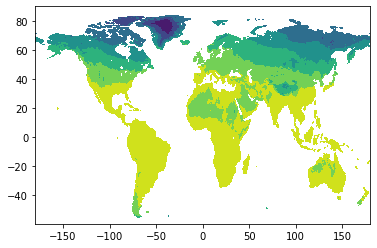

In [20]:
# mesh x and y (lon and lat coordinates)
x_mesh, y_mesh = np.meshgrid(lon, lat)

# z_mesh
z_mesh = avg_loss

# create the contour plot
# the color of the map doesn't matter as long as the contours are correct,
# because Tableau won't read any color information
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, linestyles="None", levels=levels)

save the map in geojson format

In [21]:
os.makedirs("./geojson_files", exist_ok=True)
geojsoncontour.contourf_to_geojson(contourf, geojson_filepath="./geojson_files/avg_loss.geojson")